In [81]:
### To install sib as a python package look at the sib documentation 

import sys
#sys.path.insert(0,'./src/')
#simulator_path = "../covid_de/sim/" ##change simulatio path here 
sys.path.insert(0,'src/')
simulator_path = "../simulator/sim/" ##change simulatio path here 
sys.path.insert(0, '../simulator/sim/lib/') # we need distributions.py
sys.path.insert(0,simulator_path)
sys.path.insert(0, "../epidemic_mitigation/src/") # correct rankers

from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import json, log, logging, loop_mtpp
from importlib import reload
import imp
from math import exp
import pickle
#sys.path.insert(0,'./src/loop_ranker')
from lib.mobilitysim import MobilitySimulator
import loop_mtpp
from mtpp_utils import contacts_cg
from distributions import CovidDistributions



#logging
data_path = '../simulator/sim/lib/mobility/'

output_dir = "output_Tubingen_pop1_site1/"
fold_out = Path(output_dir)
if not fold_out.exists():
    fold_out.mkdir(parents=True)

reload(log)
logger = log.setup_logger()

Log setup already done


### Mobility simulation

In [82]:
beta = 0.05  # from paper
country = 'GER'
distr = CovidDistributions(country)
# with open(data_path + 'Isle_of_Wight_settings_pop10_site5.pk', 'rb') as fp:
with open(data_path + 'Tubingen_settings_100_20.pk', 'rb') as fp:
    mob_kwargs = pickle.load(fp)

mob_kwargs["delta"] = 0.2554120904376099
T = 50
seed_mob = 2
t_unit = 24
t_res = 0.25  # drop contacts with a duration < t_res (in hours)
max_time = T * t_unit
mob = MobilitySimulator(**mob_kwargs)
mob.verbose = True
out = mob.simulate(max_time=max_time, seed=seed_mob)
N = mob.num_people
# print(N)


Simulate mobility for 1200.00 time units... 

## Set testing and quarantine rules

In [83]:
# n_indiv=np.ceil(mob_kwargs['num_people_unscaled']/mob_kwargs['downsample_pop'])
n_seeds = {'expo': 3, 'iasy': 4, 'ipre': 5}  # select initial infected seeds
num_test_random = 0  # number of random tests per day
fraction_sym_obs = 0.05  # fraction of Symptomatic tested positive
initial_steps = 5  # starting time of intervention
delta_days = 1  # intervention every delta_days days
test_HH = False
quarantine_HH = True
adoption_fraction = 1.0
probability_th = 0.0
adapt_th = False



## Set the inference algorithm class

In [84]:
import matplotlib.pyplot as plt
import sib
import scipy

from rankers import sib_rank, greedy_rank, mean_field_rank
from tqdm.notebook import tqdm
from scipy.stats import gamma
sib.set_num_threads(6)


mu = 1/12
prob_seed = 1/N
prob_sus = 0.5
pseed = prob_seed / (2 - prob_seed)
psus = prob_sus * (1 - pseed)
pautoinf = 1e-6
fp_rate = 0.0
fn_rate = 0.285

rankers = {}


rankers["MF"] = mean_field_rank.MeanFieldRanker(
                tau = 5,
                delta = 10,
                mu = mu,
                lamb = 1.0
                )
                
rankers["greedy"] = greedy_rank.GreedyRanker(
                 include_S = True,
                tau=10)

rankers["no_intervention"] = None

k_rec_gamma = 62.484380808876004
scale_rec_gamma = 0.2992112296058585
t0 = distr.incubation_mean_of_lognormal - \
    distr.median_infectious_without_symptom
alpha = 2.0
tau = 0

prob_i = sib.PiecewiseLinear(sib.RealParams(
    list(scipy.special.expit(alpha*(range(T+1) - t0*np.ones(T+1))))))
prob_r = sib.PiecewiseLinear(sib.RealParams(
    list(scipy.stats.gamma.sf(range(T+1), k_rec_gamma, scale=scale_rec_gamma))))

rankers["sib"] = sib_rank.SibRanker(
    params=sib.Params(
        prob_i=prob_i,
        prob_r=prob_r,
        pseed=pseed,
        psus=psus,
        pautoinf=pautoinf),
    maxit0=20,
    maxit1=20,
    tol=1e-3,
    memory_decay=1e-5,
    window_length=21,
    tau=tau,
    fnr=fn_rate,
    fpr=fp_rate

)




In [85]:
ress = {}
for num_test_algo in [20]:  # number of test per day by ranking
    for seed in [42]: # never use seed = 0
        print(num_test_algo, seed)
        for s in list(rankers.keys()):
            data = {"algo": s}
            if s == "no_intervention":
                res_s = loop_mtpp.free_mtpp(mob,
                                            country=country,
                                            beta=beta,
                                            T=T,
                                            seed=seed,
                                            logger=logging.getLogger(
                                                f"iteration.{s}"),
                                            data=data,
                                            initial_counts=n_seeds,
                                            name_file_res=s +
                                            f"_N_{N}_T_{T}_obs_{num_test_algo}_sym_obs_{fraction_sym_obs}_seed_{seed}",
                                            output_dir=output_dir,
                                            )
            else:
                res_s = loop_mtpp.loop_mtpp(mob,
                                            rankers[s],
                                            country=country,
                                            T=T,
                                            seed=seed,
                                            logger=logging.getLogger(
                                                f"iteration.{s}"),
                                            data=data,
                                            initial_steps=initial_steps,
                                            num_test_random=num_test_random,
                                            num_test_algo=num_test_algo,
                                            fraction_sym_obs=fraction_sym_obs,
                                            initial_counts=n_seeds,
                                            beta=beta,
                                            test_HH=test_HH,
                                            quarantine_HH=quarantine_HH,
                                            name_file_res=s +
                                            f"_N_{N}_T_{T}_obs_{num_test_algo}_sym_obs_{fraction_sym_obs}_seed_{seed}",
                                            output_dir=output_dir,
                                            save_every_iter=1,
                                            adoption_fraction=adoption_fraction,
                                            probability_th=probability_th,
                                            adapt_th=adapt_th,
                                            fp_rate=fp_rate,
                                            fn_rate=fn_rate
                                            )
            ress[s] = res_s
        del res_s


20 42
Starting with guys:  {'expo': [70, 457, 218], 'iasy': [250, 39, 855, 486], 'ipre': [110, 72, 86, 695, 448]}
t: 24.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:0
iteration.MF: INFO     adding contacts in the interval [0, 24]
iteration.MF: INFO     number of unique contacts: 2094
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.MF: INFO     AUR_I : 0.652, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+12)



[Reached max time: 24h (1d)]
All raw contacts 2114
Contacts at midnight  46
Contacts collected by coarse-graining  20
Contacts in multiple days  0
Coarse-grained contacts  2140
Missing contacts  0
Asymmetric contacts  0
t: 48.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:1
iteration.MF: INFO     adding contacts in the interval [24, 48]
iteration.MF: INFO     number of unique contacts: 2096



[Reached max time: 48h (2d)]
All raw contacts 2140
Contacts at midnight  112
Contacts collected by coarse-graining  44
Contacts in multiple days  0
Coarse-grained contacts  2208
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.MF: INFO     AUR_I : 0.652, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


t: 72.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:2
iteration.MF: INFO     adding contacts in the interval [48, 72]



[Reached max time: 72h (3d)]
All raw contacts 2340
Contacts at midnight  144
Contacts collected by coarse-graining  72
Contacts in multiple days  0
Coarse-grained contacts  2412
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of unique contacts: 2268
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.MF: INFO     AUR_I : 0.652, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


t: 96.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:3



[Reached max time: 96h (4d)]
All raw contacts 2688
Contacts at midnight  144
Contacts collected by coarse-graining  48
Contacts in multiple days  0
Coarse-grained contacts  2784
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [72, 96]
iteration.MF: INFO     number of unique contacts: 2640
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.MF: INFO     AUR_I : 0.652, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


t: 120.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:4



[Reached max time: 120h (5d)]
All raw contacts 2584
Contacts at midnight  116
Contacts collected by coarse-graining  52
Contacts in multiple days  0


iteration.MF: INFO     adding contacts in the interval [96, 120]
iteration.MF: INFO     number of unique contacts: 2532
iteration.MF: INFO     number of tests today: 0
iteration.MF: INFO     True  : (S,I,R): (890.0, 14.0, 0.0)
iteration.MF: INFO     AUR_I : 0.610, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 14 free as birds (+2)


Coarse-grained contacts  2648
Missing contacts  0
Asymmetric contacts  0
t: 144.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     
observation-based inference algorithm starts now

iteration.MF: INFO     time:5
iteration.MF: INFO     adding contacts in the interval [120, 144]
iteration.MF: INFO     number of unique contacts: 2498



[Reached max time: 144h (6d)]
All raw contacts 2538
Contacts at midnight  206
Contacts collected by coarse-graining  40
Contacts in multiple days  0
Coarse-grained contacts  2704
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (887.0, 17.0, 0.0)
iteration.MF: INFO     AUR_I : 0.582, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 17 free as birds (+3)


t: 168.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:6



[Reached max time: 168h (7d)]


iteration.MF: INFO     adding contacts in the interval [144, 168]
iteration.MF: INFO     number of unique contacts: 2550
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (887.0, 17.0, 0.0)
iteration.MF: INFO     AUR_I : 0.582, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 17 free as birds (+0)


All raw contacts 2632
Contacts at midnight  206
Contacts collected by coarse-graining  82
Contacts in multiple days  0
Coarse-grained contacts  2756
Missing contacts  0
Asymmetric contacts  0
t: 192.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:7



[Reached max time: 192h (8d)]
All raw contacts 2848
Contacts at midnight  142
Contacts collected by coarse-graining  68
Contacts in multiple days  0
Coarse-grained contacts  2922
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [168, 192]
iteration.MF: INFO     number of unique contacts: 2780
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (886.0, 18.0, 0.0)
iteration.MF: INFO     AUR_I : 0.555, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 18 free as birds (+1)


t: 216.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:8



[Reached max time: 216h (9d)]


iteration.MF: INFO     adding contacts in the interval [192, 216]
iteration.MF: INFO     number of unique contacts: 2332


All raw contacts 2374
Contacts at midnight  188
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2520
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (885.0, 19.0, 0.0)
iteration.MF: INFO     AUR_I : 0.546, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 19 free as birds (+1)


t: 240.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:9



[Reached max time: 240h (10d)]


iteration.MF: INFO     adding contacts in the interval [216, 240]
iteration.MF: INFO     number of unique contacts: 2488


All raw contacts 2540
Contacts at midnight  138
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2626
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (883.0, 21.0, 0.0)
iteration.MF: INFO     AUR_I : 0.551, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 21 free as birds (+2)


t: 264.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:10



[Reached max time: 264h (11d)]


iteration.MF: INFO     adding contacts in the interval [240, 264]
iteration.MF: INFO     number of unique contacts: 1968


All raw contacts 2010
Contacts at midnight  118
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2086
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (882.0, 22.0, 0.0)
iteration.MF: INFO     AUR_I : 0.531, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 22 free as birds (+1)


t: 288.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:11



[Reached max time: 288h (12d)]
All raw contacts 2356
Contacts at midnight  150
Contacts collected by coarse-graining  58
Contacts in multiple days  0
Coarse-grained contacts  2448
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [264, 288]
iteration.MF: INFO     number of unique contacts: 2298
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (881.0, 23.0, 0.0)
iteration.MF: INFO     AUR_I : 0.536, prec100: 5, prec(1% of 904): 0.00, prec5%: 0.04
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 22 free as birds (+0)


t: 312.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:12



[Reached max time: 312h (13d)]


iteration.MF: INFO     adding contacts in the interval [288, 312]
iteration.MF: INFO     number of unique contacts: 2522
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (881.0, 21.0, 2.0)
iteration.MF: INFO     AUR_I : 0.551, prec100: 5, prec(1% of 904): 0.00, prec5%: 0.04
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 20 free as birds (-2)


All raw contacts 2566
Contacts at midnight  126
Contacts collected by coarse-graining  44
Contacts in multiple days  0
Coarse-grained contacts  2648
Missing contacts  0
Asymmetric contacts  0
t: 336.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:13



[Reached max time: 336h (14d)]


iteration.MF: INFO     adding contacts in the interval [312, 336]


All raw contacts 2382
Contacts at midnight  144
Contacts collected by coarse-graining  84
Contacts in multiple days  0
Coarse-grained contacts  2442
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of unique contacts: 2298
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (880.0, 20.0, 4.0)
iteration.MF: INFO     AUR_I : 0.528, prec100: 4, prec(1% of 904): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 19 free as birds (-1)


t: 360.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:14



[Reached max time: 360h (15d)]
All raw contacts 2992
Contacts at midnight  156
Contacts collected by coarse-graining  70
Contacts in multiple days  0
Coarse-grained contacts  3078
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [336, 360]
iteration.MF: INFO     number of unique contacts: 2922
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (878.0, 19.0, 7.0)
iteration.MF: INFO     AUR_I : 0.493, prec100: 3, prec(1% of 904): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 18 free as birds (-1)


t: 384.00 | 1200.00 hrs (50 d)
[Reached max time: 384h (16d)]


iteration.MF: INFO     time:15
iteration.MF: INFO     adding contacts in the interval [360, 384]
iteration.MF: INFO     number of unique contacts: 2222


All raw contacts 2272
Contacts at midnight  116
Contacts collected by coarse-graining  50
Contacts in multiple days  0
Coarse-grained contacts  2338
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (875.0, 21.0, 8.0)
iteration.MF: INFO     AUR_I : 0.464, prec100: 2, prec(1% of 902): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 2 guys -> got 2 infected, 18 free as birds (+0)


t: 408.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:16



[Reached max time: 408h (17d)]


iteration.MF: INFO     adding contacts in the interval [384, 408]
iteration.MF: INFO     number of unique contacts: 2312


All raw contacts 2370
Contacts at midnight  142
Contacts collected by coarse-graining  36
Contacts in multiple days  0
Coarse-grained contacts  2476
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (875.0, 21.0, 8.0)
iteration.MF: INFO     AUR_I : 0.594, prec100: 3, prec(1% of 897): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (17,2,1), infected test random: 0/0
iteration.MF: INFO     ...quarantining 5 guys -> got 4 infected, 14 free as birds (-4)


t: 432.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:17



[Reached max time: 432h (18d)]


iteration.MF: INFO     adding contacts in the interval [408, 432]
iteration.MF: INFO     number of unique contacts: 2476


All raw contacts 2572
Contacts at midnight  150
Contacts collected by coarse-graining  72
Contacts in multiple days  0
Coarse-grained contacts  2650
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (875.0, 20.0, 9.0)
iteration.MF: INFO     AUR_I : 0.508, prec100: 3, prec(1% of 896): 0.12, prec5%: 0.05
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 14 free as birds (+0)


t: 456.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:18



[Reached max time: 456h (19d)]


iteration.MF: INFO     adding contacts in the interval [432, 456]


All raw contacts 2684
Contacts at midnight  160
Contacts collected by coarse-graining  74
Contacts in multiple days  0
Coarse-grained contacts  2770
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of unique contacts: 2564
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (872.0, 22.0, 10.0)
iteration.MF: INFO     AUR_I : 0.445, prec100: 0, prec(1% of 896): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 16 free as birds (+2)


t: 480.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:19



[Reached max time: 480h (20d)]


iteration.MF: INFO     adding contacts in the interval [456, 480]
iteration.MF: INFO     number of unique contacts: 2114


All raw contacts 2194
Contacts at midnight  148
Contacts collected by coarse-graining  50
Contacts in multiple days  0
Coarse-grained contacts  2292
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (872.0, 22.0, 10.0)
iteration.MF: INFO     AUR_I : 0.477, prec100: 1, prec(1% of 896): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 16 free as birds (+0)


t: 504.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:20



[Reached max time: 504h (21d)]
All raw contacts 2726
Contacts at midnight  104
Contacts collected by coarse-graining  60
Contacts in multiple days  0
Coarse-grained contacts  2770
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [480, 504]
iteration.MF: INFO     number of unique contacts: 2640
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (870.0, 23.0, 11.0)
iteration.MF: INFO     AUR_I : 0.504, prec100: 2, prec(1% of 896): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 16 free as birds (+0)


t: 528.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:21



[Reached max time: 528h (22d)]


iteration.MF: INFO     adding contacts in the interval [504, 528]
iteration.MF: INFO     number of unique contacts: 2530
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (869.0, 20.0, 15.0)
iteration.MF: INFO     AUR_I : 0.502, prec100: 1, prec(1% of 895): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0


All raw contacts 2646
Contacts at midnight  158
Contacts collected by coarse-graining  92
Contacts in multiple days  0
Coarse-grained contacts  2712
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     ...quarantining 1 guys -> got 1 infected, 12 free as birds (-4)


t: 552.00 | 1200.00 hrs (50 d)
[Reached max time: 552h (23d)]


iteration.MF: INFO     time:22


All raw contacts 2530
Contacts at midnight  168
Contacts collected by coarse-graining  70
Contacts in multiple days  0
Coarse-grained contacts  2628
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [528, 552]
iteration.MF: INFO     number of unique contacts: 2398
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (866.0, 22.0, 16.0)
iteration.MF: INFO     AUR_I : 0.511, prec100: 1, prec(1% of 895): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (19,0,1), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 14 free as birds (+2)


t: 576.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:23



[Reached max time: 576h (24d)]
All raw contacts

iteration.MF: INFO     adding contacts in the interval [552, 576]
iteration.MF: INFO     number of unique contacts: 2408


 2572
Contacts at midnight  122
Contacts collected by coarse-graining  62
Contacts in multiple days  0
Coarse-grained contacts  2632
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (863.0, 25.0, 16.0)
iteration.MF: INFO     AUR_I : 0.564, prec100: 1, prec(1% of 892): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (17,2,1), infected test random: 0/0
iteration.MF: INFO     ...quarantining 2 guys -> got 1 infected, 16 free as birds (+2)


t: 600.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:24



[Reached max time: 600h (25d)]


iteration.MF: INFO     adding contacts in the interval [576, 600]
iteration.MF: INFO     number of unique contacts: 2372


All raw contacts 2476
Contacts at midnight  120
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2554
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (862.0, 24.0, 18.0)
iteration.MF: INFO     AUR_I : 0.442, prec100: 1, prec(1% of 890): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 2 guys -> got 2 infected, 15 free as birds (-1)


t: 624.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:25



[Reached max time: 624h (26d)]


iteration.MF: INFO     adding contacts in the interval [600, 624]
iteration.MF: INFO     number of unique contacts: 2684


All raw contacts 2758
Contacts at midnight  144
Contacts collected by coarse-graining  46
Contacts in multiple days  0
Coarse-grained contacts  2856
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (860.0, 26.0, 18.0)
iteration.MF: INFO     AUR_I : 0.466, prec100: 0, prec(1% of 890): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 17 free as birds (+2)


t: 648.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:26



[Reached max time: 648h (27d)]


iteration.MF: INFO     adding contacts in the interval [624, 648]
iteration.MF: INFO     number of unique contacts: 2356


All raw contacts 2404
Contacts at midnight  212
Contacts collected by coarse-graining  24
Contacts in multiple days  0
Coarse-grained contacts  2592
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (857.0, 26.0, 21.0)
iteration.MF: INFO     AUR_I : 0.623, prec100: 1, prec(1% of 890): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 19 free as birds (+2)


t: 672.00 | 1200.00 hrs (50 d)
[Reached max time: 672h (28d)]


iteration.MF: INFO     time:27


All raw contacts 2412
Contacts at midnight  204
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2564
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [648, 672]
iteration.MF: INFO     number of unique contacts: 2314
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (857.0, 26.0, 21.0)
iteration.MF: INFO     AUR_I : 0.558, prec100: 2, prec(1% of 884): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (18,2,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 6 guys -> got 3 infected, 16 free as birds (-3)


t: 696.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:28



[Reached max time: 696h (29d)]


iteration.MF: INFO     adding contacts in the interval [672, 696]
iteration.MF: INFO     number of unique contacts: 2450


All raw contacts 2578
Contacts at midnight  166
Contacts collected by coarse-graining  54
Contacts in multiple days  0
Coarse-grained contacts  2690
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (854.0, 29.0, 21.0)
iteration.MF: INFO     AUR_I : 0.574, prec100: 0, prec(1% of 880): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 4 guys -> got 4 infected, 13 free as birds (-3)


t: 720.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:29



[Reached max time: 720h (30d)]


iteration.MF: INFO     adding contacts in the interval [696, 720]
iteration.MF: INFO     number of unique contacts: 2026


All raw contacts 2230
Contacts at midnight  146
Contacts collected by coarse-graining  82
Contacts in multiple days  0
Coarse-grained contacts  2294
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (853.0, 30.0, 21.0)
iteration.MF: INFO     AUR_I : 0.581, prec100: 3, prec(1% of 880): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 13 free as birds (+0)


t: 744.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:30



[Reached max time: 744h (31d)]


iteration.MF: INFO     adding contacts in the interval [720, 744]
iteration.MF: INFO     number of unique contacts: 2378


All raw contacts 2490
Contacts at midnight  136
Contacts collected by coarse-graining  32
Contacts in multiple days  0
Coarse-grained contacts  2594
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (853.0, 30.0, 21.0)
iteration.MF: INFO     AUR_I : 0.601, prec100: 3, prec(1% of 879): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (-1)


t: 768.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:31



[Reached max time: 768h (32d)]
All raw contacts

iteration.MF: INFO     adding contacts in the interval [744, 768]
iteration.MF: INFO     number of unique contacts: 2276


 2436
Contacts at midnight  156
Contacts collected by coarse-graining  76
Contacts in multiple days  0
Coarse-grained contacts  2516
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (852.0, 26.0, 26.0)
iteration.MF: INFO     AUR_I : 0.500, prec100: 2, prec(1% of 879): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


t: 792.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:32



[Reached max time: 792h (33d)]
All raw contacts 2378


iteration.MF: INFO     adding contacts in the interval [768, 792]
iteration.MF: INFO     number of unique contacts: 2240
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (851.0, 26.0, 27.0)
iteration.MF: INFO     AUR_I : 0.597, prec100: 1, prec(1% of 879): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


Contacts at midnight  178
Contacts collected by coarse-graining  54
Contacts in multiple days  0
Coarse-grained contacts  2502
Missing contacts  0
Asymmetric contacts  0
t: 816.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:33



[Reached max time: 816h (34d)]
All raw contacts 2312
Contacts at midnight  178
Contacts collected by coarse-graining  34
Contacts in multiple days  0
Coarse-grained contacts  2456
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [792, 816]
iteration.MF: INFO     number of unique contacts: 2190
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (849.0, 27.0, 28.0)
iteration.MF: INFO     AUR_I : 0.569, prec100: 1, prec(1% of 879): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 13 free as birds (+1)


t: 840.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:34



[Reached max time: 840h (35d)]


iteration.MF: INFO     adding contacts in the interval [816, 840]
iteration.MF: INFO     number of unique contacts: 2524


All raw contacts 2742
Contacts at midnight  136
Contacts collected by coarse-graining  48
Contacts in multiple days  0
Coarse-grained contacts  2830
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (849.0, 26.0, 29.0)
iteration.MF: INFO     AUR_I : 0.525, prec100: 1, prec(1% of 878): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 11 free as birds (-2)


t: 864.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:35



[Reached max time: 864h (36d)]


iteration.MF: INFO     adding contacts in the interval [840, 864]
iteration.MF: INFO     number of unique contacts: 2506


All raw contacts 2686
Contacts at midnight  126
Contacts collected by coarse-graining  78
Contacts in multiple days  0
Coarse-grained contacts  2734
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (845.0, 29.0, 30.0)
iteration.MF: INFO     AUR_I : 0.589, prec100: 2, prec(1% of 878): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 15 free as birds (+4)


t: 888.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:36



[Reached max time: 888h (37d)]


iteration.MF: INFO     adding contacts in the interval [864, 888]
iteration.MF: INFO     number of unique contacts: 2356


All raw contacts 2544
Contacts at midnight  146
Contacts collected by coarse-graining  34
Contacts in multiple days  0
Coarse-grained contacts  2656
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (842.0, 31.0, 31.0)
iteration.MF: INFO     AUR_I : 0.577, prec100: 2, prec(1% of 878): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 18 free as birds (+3)


t: 912.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:37



[Reached max time: 912h (38d)]


iteration.MF: INFO     adding contacts in the interval [888, 912]
iteration.MF: INFO     number of unique contacts: 2488


All raw contacts 2672
Contacts at midnight  118
Contacts collected by coarse-graining  58
Contacts in multiple days  0
Coarse-grained contacts  2732
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (841.0, 31.0, 32.0)
iteration.MF: INFO     AUR_I : 0.562, prec100: 2, prec(1% of 878): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 18 free as birds (+0)


t: 936.00 | 1200.00 hrs (50 d)
[Reached max time: 936h (39d)]


iteration.MF: INFO     time:38
iteration.MF: INFO     adding contacts in the interval [912, 936]
iteration.MF: INFO     number of unique contacts: 1836


All raw contacts 1944
Contacts at midnight  78
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  1980
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (839.0, 30.0, 35.0)
iteration.MF: INFO     AUR_I : 0.486, prec100: 2, prec(1% of 878): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 18 free as birds (+0)


t: 960.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:39



[Reached max time: 960h (40d)]
All raw contacts 2490
Contacts at midnight  130
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2568
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     adding contacts in the interval [936, 960]
iteration.MF: INFO     number of unique contacts: 2252
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (838.0, 30.0, 36.0)
iteration.MF: INFO     AUR_I : 0.465, prec100: 2, prec(1% of 878): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 19 free as birds (+1)


t: 984.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:40



[Reached max time: 984h (41d)]


iteration.MF: INFO     adding contacts in the interval [960, 984]
iteration.MF: INFO     number of unique contacts: 2256


All raw contacts 2426
Contacts at midnight  216
Contacts collected by coarse-graining  26
Contacts in multiple days  0
Coarse-grained contacts  2616
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (837.0, 29.0, 38.0)
iteration.MF: INFO     AUR_I : 0.486, prec100: 2, prec(1% of 878): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 20 free as birds (+1)


t: 1008.00 | 1200.00 hrs (50 d)
[Reached max time: 1008h (42d)]


iteration.MF: INFO     time:41
iteration.MF: INFO     adding contacts in the interval [984, 1008]
iteration.MF: INFO     number of unique contacts: 2502
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (834.0, 30.0, 40.0)
iteration.MF: INFO     AUR_I : 0.482, prec100: 2, prec(1% of 878): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 23 free as birds (+3)


All raw contacts 2648
Contacts at midnight  212
Contacts collected by coarse-graining  34
Contacts in multiple days  0
Coarse-grained contacts  2826
Missing contacts  0
Asymmetric contacts  0
t: 1032.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:42



[Reached max time: 1032h (43d)]


iteration.MF: INFO     adding contacts in the interval [1008, 1032]
iteration.MF: INFO     number of unique contacts: 2574


All raw contacts 2850
Contacts at midnight  138
Contacts collected by coarse-graining  56
Contacts in multiple days  0
Coarse-grained contacts  2932
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (829.0, 32.0, 43.0)
iteration.MF: INFO     AUR_I : 0.468, prec100: 2, prec(1% of 878): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 26 free as birds (+3)


t: 1056.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:43



[Reached max time: 1056h (44d)]


iteration.MF: INFO     adding contacts in the interval [1032, 1056]
iteration.MF: INFO     number of unique contacts: 2376


All raw contacts 2528
Contacts at midnight  92
Contacts collected by coarse-graining  30
Contacts in multiple days  0
Coarse-grained contacts  2590
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (828.0, 31.0, 45.0)
iteration.MF: INFO     AUR_I : 0.458, prec100: 1, prec(1% of 874): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 4 guys -> got 4 infected, 23 free as birds (-3)


t: 1080.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:44



[Reached max time: 1080h (45d)]


iteration.MF: INFO     adding contacts in the interval [1056, 1080]


All raw contacts 2424
Contacts at midnight  110
Contacts collected by coarse-graining  24
Contacts in multiple days  0
Coarse-grained contacts  2510
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of unique contacts: 2248
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (824.0, 32.0, 48.0)
iteration.MF: INFO     AUR_I : 0.440, prec100: 1, prec(1% of 868): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (17,3,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 6 guys -> got 6 infected, 20 free as birds (-3)


t: 1104.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:45



[Reached max time: 1104h (46d)]
All raw contacts 2134
Contacts at midnight  126
Contacts collected by coarse-graining  50

iteration.MF: INFO     adding contacts in the interval [1080, 1104]
iteration.MF: INFO     number of unique contacts: 1878



Contacts in multiple days  0
Coarse-grained contacts  2210
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (822.0, 32.0, 50.0)
iteration.MF: INFO     AUR_I : 0.470, prec100: 1, prec(1% of 861): 0.00, prec5%: 0.02
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (15,4,1), infected test random: 0/0
iteration.MF: INFO     ...quarantining 7 guys -> got 5 infected, 17 free as birds (-3)


t: 1128.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:46



[Reached max time: 1128h (47d)]
All raw contacts 2316
Contacts at midnight  148
Contacts collected by coarse-graining 

iteration.MF: INFO     adding contacts in the interval [1104, 1128]
iteration.MF: INFO     number of unique contacts: 2114


 48
Contacts in multiple days  0
Coarse-grained contacts  2416
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (819.0, 35.0, 50.0)
iteration.MF: INFO     AUR_I : 0.470, prec100: 1, prec(1% of 855): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.MF: INFO     ...quarantining 5 guys -> got 1 infected, 19 free as birds (+2)


t: 1152.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:47



[Reached max time: 1152h (48d)]


iteration.MF: INFO     adding contacts in the interval [1128, 1152]
iteration.MF: INFO     number of unique contacts: 2078


All raw contacts 2328
Contacts at midnight  152
Contacts collected by coarse-graining  30
Contacts in multiple days  0
Coarse-grained contacts  2450
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (816.0, 38.0, 50.0)
iteration.MF: INFO     AUR_I : 0.495, prec100: 2, prec(1% of 855): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (18,0,2), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 20 free as birds (+1)


t: 1176.00 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:48



[Reached max time: 1176h (49d)]
All raw contacts 2432
Contacts at midnight  134
Contacts collected by coarse-graining  56
Contacts in multiple days  0
Coarse-grained contacts  2510
Missing contacts  0
Asymmetric contacts 

iteration.MF: INFO     adding contacts in the interval [1152, 1176]
iteration.MF: INFO     number of unique contacts: 2142


 0


iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (811.0, 43.0, 50.0)
iteration.MF: INFO     AUR_I : 0.522, prec100: 4, prec(1% of 853): 0.00, prec5%: 0.00
iteration.MF: INFO     sym: 0, results test algo (S,I,R): (19,0,1), infected test random: 0/0
iteration.MF: INFO     ...quarantining 0 guys -> got 0 infected, 23 free as birds (+3)


t: 1199.76 | 1200.00 hrs (50 d)

iteration.MF: INFO     time:49
iteration.MF: INFO     adding contacts in the interval [1176, 1200]


All raw contacts 2582
Contacts at midnight  78
Contacts collected by coarse-graining  64
Contacts in multiple days  0
Coarse-grained contacts  2596
Missing contacts  0
Asymmetric contacts  0


iteration.MF: INFO     number of unique contacts: 2252
iteration.MF: INFO     number of tests today: 20
iteration.MF: INFO     True  : (S,I,R): (807.0, 44.0, 53.0)
iteration.MF: INFO     AUR_I : 0.527, prec100: 5, prec(1% of 852): 0.00, prec5%: 0.05
iteration.MF: INFO     sym: 1, results test algo (S,I,R): (18,1,1), infected test random: 0/0
iteration.MF: INFO     ...quarantining 2 guys -> got 2 infected, 22 free as birds (-1)


Time  8.935527563095093
Starting with guys:  {'expo': [70, 457, 218], 'iasy': [250, 39, 855, 486], 'ipre': [110, 72, 86, 695, 448]}
t: 24.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:0
iteration.greedy: INFO     adding contacts in the interval [0, 24]
iteration.greedy: INFO     number of unique contacts: 2094
iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.607, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.04
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+12)



[Reached max time: 24h (1d)]
All raw contacts 2114
Contacts at midnight  46
Contacts collected by coarse-graining  20
Contacts in multiple days  0
Coarse-grained contacts  2140
Missing contacts  0
Asymmetric contacts  0
all contacts: 2094
all contacts cut: 0
t: 48.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:1



[Reached max time: 48h (2d)]


iteration.greedy: INFO     adding contacts in the interval [24, 48]
iteration.greedy: INFO     number of unique contacts: 2096
iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.601, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


All raw contacts 2140
Contacts at midnight  112
Contacts collected by coarse-graining  44
Contacts in multiple days  0
Coarse-grained contacts  2208
Missing contacts  0
Asymmetric contacts  0
all contacts: 4190
all contacts cut: 0
t: 72.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:2



[Reached max time: 72h (3d)]


iteration.greedy: INFO     adding contacts in the interval [48, 72]
iteration.greedy: INFO     number of unique contacts: 2268


All raw contacts 2340
Contacts at midnight  144
Contacts collected by coarse-graining  72
Contacts in multiple days  0
Coarse-grained contacts  2412
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.643, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


all contacts: 6458
all contacts cut: 0
t: 96.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:3



[Reached max time: 96h (4d)]


iteration.greedy: INFO     adding contacts in the interval [72, 96]
iteration.greedy: INFO     number of unique contacts: 2640


All raw contacts 2688
Contacts at midnight  144
Contacts collected by coarse-graining  48
Contacts in multiple days  0
Coarse-grained contacts  2784
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.631, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


all contacts: 9098
all contacts cut: 0
t: 120.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:4



[Reached max time: 120h (5d)]


iteration.greedy: INFO     adding contacts in the interval [96, 120]
iteration.greedy: INFO     number of unique contacts: 2532
iteration.greedy: INFO     number of tests today: 0
iteration.greedy: INFO     True  : (S,I,R): (890.0, 14.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.622, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 14 free as birds (+2)


All raw contacts 2584
Contacts at midnight  116
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2648
Missing contacts  0
Asymmetric contacts  0
all contacts: 11630
all contacts cut: 0
t: 144.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     
observation-based inference algorithm starts now

iteration.greedy: INFO     time:5



[Reached max time: 144h (6d)]


iteration.greedy: INFO     adding contacts in the interval [120, 144]
iteration.greedy: INFO     number of unique contacts: 2498


All raw contacts 2538
Contacts at midnight  206
Contacts collected by coarse-graining  40
Contacts in multiple days  0
Coarse-grained contacts  2704
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (887.0, 17.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.567, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 17 free as birds (+3)


all contacts: 14128
all contacts cut: 0
t: 168.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:6



[Reached max time: 168h (7d)]


iteration.greedy: INFO     adding contacts in the interval [144, 168]
iteration.greedy: INFO     number of unique contacts: 2550


All raw contacts 2632
Contacts at midnight  206
Contacts collected by coarse-graining  82
Contacts in multiple days  0
Coarse-grained contacts  2756
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 20


all contacts: 16678
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (887.0, 17.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.586, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 17 free as birds (+0)


t: 192.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:7



[Reached max time: 192h (8d)]


iteration.greedy: INFO     adding contacts in the interval [168, 192]
iteration.greedy: INFO     number of unique contacts: 2780


All raw contacts 2848
Contacts at midnight  142
Contacts collected by coarse-graining  68
Contacts in multiple days  0
Coarse-grained contacts  2922
Missing contacts  0
Asymmetric contacts  0
all contacts: 19458
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (886.0, 18.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.558, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 18 free as birds (+1)


t: 216.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:8



[Reached max time: 216h (9d)]


iteration.greedy: INFO     adding contacts in the interval [192, 216]
iteration.greedy: INFO     number of unique contacts: 2332


All raw contacts 2374
Contacts at midnight  188
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2520
Missing contacts  0
Asymmetric contacts  0
all contacts: 21790
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (885.0, 19.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.548, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 19 free as birds (+1)


t: 240.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:9



[Reached max time: 240h (10d)]


iteration.greedy: INFO     adding contacts in the interval [216, 240]
iteration.greedy: INFO     number of unique contacts: 2488


All raw contacts 2540
Contacts at midnight  138
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2626
Missing contacts  0
Asymmetric contacts  0
all contacts: 24278
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (883.0, 21.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.552, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 21 free as birds (+2)


t: 264.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:10



[Reached max time: 264h (11d)]


iteration.greedy: INFO     adding contacts in the interval [240, 264]
iteration.greedy: INFO     number of unique contacts: 1968


All raw contacts 2010
Contacts at midnight  118
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2086
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (882.0, 22.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.531, prec100: 4, prec(1% of 905): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 22 free as birds (+1)


all contacts: 26246
all contacts cut: 0
t: 288.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:11



[Reached max time: 288h (12d)]
All raw contacts 2356
Contacts at midnight  150
Contacts collected by coarse-graining  58
Contacts in multiple days  0
Coarse-grained contacts  2448
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [264, 288]
iteration.greedy: INFO     number of unique contacts: 2298
iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (881.0, 23.0, 0.0)
iteration.greedy: INFO     AUR_I : 0.501, prec100: 2, prec(1% of 903): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 1 guys -> got 1 infected, 21 free as birds (-1)


all contacts: 2298
all contacts cut: 0
t: 312.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:12



[Reached max time: 312h (13d)]
All raw contacts 2566
Contacts at midnight  126
Contacts collected by coarse-graining  44
Contacts in multiple days  0
Coarse-grained contacts  2648
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     adding contacts in the interval [288, 312]
iteration.greedy: INFO     number of unique contacts: 2520
iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (881.0, 21.0, 2.0)
iteration.greedy: INFO     AUR_I : 0.540, prec100: 3, prec(1% of 896): 0.00, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (18,2,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 7 guys -> got 7 infected, 12 free as birds (-9)


all contacts: 4818
all contacts cut: 8
t: 336.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:13



[Reached max time: 336h (14d)]


iteration.greedy: INFO     adding contacts in the interval [312, 336]
iteration.greedy: INFO     number of unique contacts: 2294
iteration.greedy: INFO     number of tests today: 20


All raw contacts 2382
Contacts at midnight  144
Contacts collected by coarse-graining  84
Contacts in multiple days  0
Coarse-grained contacts  2442
Missing contacts  0
Asymmetric contacts  0
all contacts: 7112
all contacts cut: 41


iteration.greedy: INFO     True  : (S,I,R): (880.0, 20.0, 4.0)
iteration.greedy: INFO     AUR_I : 0.540, prec100: 2, prec(1% of 896): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 11 free as birds (-1)


t: 360.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:14



[Reached max time: 360h (15d)]
All raw contacts 2992


iteration.greedy: INFO     adding contacts in the interval [336, 360]
iteration.greedy: INFO     number of unique contacts: 2874


Contacts at midnight  156
Contacts collected by coarse-graining  70
Contacts in multiple days  0
Coarse-grained contacts  3078
Missing contacts  0
Asymmetric contacts  0
all contacts: 9986
all contacts cut: 41


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (878.0, 19.0, 7.0)
iteration.greedy: INFO     AUR_I : 0.459, prec100: 2, prec(1% of 896): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 10 free as birds (-1)


t: 384.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:15



[Reached max time: 384h (16d)]


iteration.greedy: INFO     adding contacts in the interval [360, 384]
iteration.greedy: INFO     number of unique contacts: 2164
iteration.greedy: INFO     number of tests today: 20


All raw contacts 2272
Contacts at midnight  116
Contacts collected by coarse-graining  50
Contacts in multiple days  0
Coarse-grained contacts  2338
Missing contacts  0
Asymmetric contacts  0
all contacts: 12150
all contacts cut: 41


iteration.greedy: INFO     True  : (S,I,R): (876.0, 20.0, 8.0)
iteration.greedy: INFO     AUR_I : 0.375, prec100: 1, prec(1% of 894): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 2 guys -> got 2 infected, 9 free as birds (-1)


t: 408.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:16



[Reached max time: 408h (17d)]


iteration.greedy: INFO     adding contacts in the interval [384, 408]
iteration.greedy: INFO     number of unique contacts: 2252


All raw contacts 2370
Contacts at midnight  142
Contacts collected by coarse-graining  36
Contacts in multiple days  0
Coarse-grained contacts  2476
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (876.0, 20.0, 8.0)
iteration.greedy: INFO     AUR_I : 0.342, prec100: 1, prec(1% of 889): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (17,2,1), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 5 guys -> got 4 infected, 5 free as birds (-4)


all contacts: 14402
all contacts cut: 80
t: 432.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:17



[Reached max time: 432h (18d)]


iteration.greedy: INFO     adding contacts in the interval [408, 432]
iteration.greedy: INFO     number of unique contacts: 2444
iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (876.0, 19.0, 9.0)
iteration.greedy: INFO     AUR_I : 0.485, prec100: 2, prec(1% of 888): 0.12, prec5%: 0.02
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 5 free as birds (+0)


All raw contacts 2572
Contacts at midnight  150
Contacts collected by coarse-graining  72
Contacts in multiple days  0
Coarse-grained contacts  2650
Missing contacts  0
Asymmetric contacts  0
all contacts: 16846
all contacts cut: 105
t: 456.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:18



[Reached max time: 456h (19d)]


iteration.greedy: INFO     adding contacts in the interval [432, 456]
iteration.greedy: INFO     number of unique contacts: 2514


All raw contacts 2684
Contacts at midnight  160
Contacts collected by coarse-graining  74
Contacts in multiple days  0
Coarse-grained contacts  2770
Missing contacts  0
Asymmetric contacts  0
all contacts: 19360
all contacts cut: 105


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (875.0, 19.0, 10.0)
iteration.greedy: INFO     AUR_I : 0.206, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 5 free as birds (+0)


t: 480.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:19



[Reached max time: 480h (20d)]


iteration.greedy: INFO     adding contacts in the interval [456, 480]
iteration.greedy: INFO     number of unique contacts: 2076


All raw contacts 2194
Contacts at midnight  148
Contacts collected by coarse-graining  50
Contacts in multiple days  0
Coarse-grained contacts  2292
Missing contacts  0
Asymmetric contacts  0
all contacts: 21436
all contacts cut: 105


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (875.0, 19.0, 10.0)
iteration.greedy: INFO     AUR_I : 0.204, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 5 free as birds (+0)


t: 504.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:20



[Reached max time: 504h (21d)]


iteration.greedy: INFO     adding contacts in the interval [480, 504]
iteration.greedy: INFO     number of unique contacts: 2582


All raw contacts 2726
Contacts at midnight  104
Contacts collected by coarse-graining  60
Contacts in multiple days  0
Coarse-grained contacts  2770
Missing contacts  0
Asymmetric contacts  0
all contacts: 24018
all contacts cut: 105


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 19.0, 11.0)
iteration.greedy: INFO     AUR_I : 0.204, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 5 free as birds (+0)


t: 528.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:21
iteration.greedy: INFO     adding contacts in the interval [504, 528]



[Reached max time: 528h (22d)]
All raw contacts 2646
Contacts at midnight  158
Contacts collected by coarse-graining  92
Contacts in multiple days  0
Coarse-grained contacts  2712
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of unique contacts: 2500
iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 15.0, 15.0)
iteration.greedy: INFO     AUR_I : 0.204, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 5 free as birds (+0)


all contacts: 26518
all contacts cut: 105
t: 552.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:22
iteration.greedy: INFO     adding contacts in the interval [528, 552]
iteration.greedy: INFO     number of unique contacts: 2352



[Reached max time: 552h (23d)]
All raw contacts 2530
Contacts at midnight  168
Contacts collected by coarse-graining  70
Contacts in multiple days  0
Coarse-grained contacts  2628
Missing contacts  0
Asymmetric contacts  0
all contacts: 2352


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 14.0, 16.0)
iteration.greedy: INFO     AUR_I : 0.364, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 4 free as birds (-1)


all contacts cut: 0
t: 576.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:23
iteration.greedy: INFO     adding contacts in the interval [552, 576]
iteration.greedy: INFO     number of unique contacts: 2374



[Reached max time: 576h (24d)]
All raw contacts 2572
Contacts at midnight  122
Contacts collected by coarse-graining  62
Contacts in multiple days  0
Coarse-grained contacts  2632
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 14.0, 16.0)
iteration.greedy: INFO     AUR_I : 0.299, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 4 free as birds (+0)


all contacts: 4726
all contacts cut: 0
t: 600.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:24
iteration.greedy: INFO     adding contacts in the interval [576, 600]
iteration.greedy: INFO     number of unique contacts: 2370



[Reached max time: 600h (25d)]
All raw contacts 2476
Contacts at midnight  120
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2554
Missing contacts  0
Asymmetric contacts  0
all contacts: 7096
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 12.0, 18.0)
iteration.greedy: INFO     AUR_I : 0.206, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 4 free as birds (+0)


t: 624.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:25
iteration.greedy: INFO     adding contacts in the interval [600, 624]
iteration.greedy: INFO     number of unique contacts: 2662
iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 12.0, 18.0)
iteration.greedy: INFO     AUR_I : 0.177, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 4 free as birds (+0)



[Reached max time: 624h (26d)]
All raw contacts 2758
Contacts at midnight  144
Contacts collected by coarse-graining  46
Contacts in multiple days  0
Coarse-grained contacts  2856
Missing contacts  0
Asymmetric contacts  0
all contacts: 9758
all contacts cut: 0
t: 648.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:26
iteration.greedy: INFO     adding contacts in the interval [624, 648]
iteration.greedy: INFO     number of unique contacts: 2322
iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 9.0, 21.0)
iteration.greedy: INFO     AUR_I : 0.232, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 4 free as birds (+0)



[Reached max time: 648h (27d)]
All raw contacts 2404
Contacts at midnight  212
Contacts collected by coarse-graining  24
Contacts in multiple days  0
Coarse-grained contacts  2592
Missing contacts  0
Asymmetric contacts  0
all contacts: 12080
all contacts cut: 0
t: 672.00 | 1200.00 hrs (50 d)
[Reached max time: 672h (28d)]


iteration.greedy: INFO     time:27
iteration.greedy: INFO     adding contacts in the interval [648, 672]
iteration.greedy: INFO     number of unique contacts: 2310


All raw contacts 2412
Contacts at midnight  204
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2564
Missing contacts  0
Asymmetric contacts  0
all contacts: 14390
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 9.0, 21.0)
iteration.greedy: INFO     AUR_I : 0.226, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 4 free as birds (+0)


t: 696.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:28



[Reached max time: 696h (29d)]


iteration.greedy: INFO     adding contacts in the interval [672, 696]
iteration.greedy: INFO     number of unique contacts: 2466


All raw contacts 2578
Contacts at midnight  166
Contacts collected by coarse-graining  54
Contacts in multiple days  0
Coarse-grained contacts  2690
Missing contacts  0
Asymmetric contacts  0
all contacts: 16856
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 9.0, 21.0)
iteration.greedy: INFO     AUR_I : 0.224, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 4 free as birds (+0)


t: 720.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:29



[Reached max time: 720h (30d)]


iteration.greedy: INFO     adding contacts in the interval [696, 720]
iteration.greedy: INFO     number of unique contacts: 2080


All raw contacts 2230
Contacts at midnight  146
Contacts collected by coarse-graining  82
Contacts in multiple days  0
Coarse-grained contacts  2294
Missing contacts  0
Asymmetric contacts  0
all contacts: 18936
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 9.0, 21.0)
iteration.greedy: INFO     AUR_I : 0.222, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 4 free as birds (+0)


t: 744.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:30



[Reached max time: 744h (31d)]


iteration.greedy: INFO     adding contacts in the interval [720, 744]
iteration.greedy: INFO     number of unique contacts: 2412


All raw contacts 2490
Contacts at midnight  136
Contacts collected by coarse-graining  32
Contacts in multiple days  0
Coarse-grained contacts  2594
Missing contacts  0
Asymmetric contacts  0
all contacts: 21348
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 9.0, 21.0)
iteration.greedy: INFO     AUR_I : 0.219, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 4 free as birds (+0)


t: 768.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:31



[Reached max time: 768h (32d)]


iteration.greedy: INFO     adding contacts in the interval [744, 768]
iteration.greedy: INFO     number of unique contacts: 2294


All raw contacts 2436
Contacts at midnight  156
Contacts collected by coarse-graining  76
Contacts in multiple days  0
Coarse-grained contacts  2516
Missing contacts  0
Asymmetric contacts  0
all contacts: 23642
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 4.0, 26.0)
iteration.greedy: INFO     AUR_I : 0.212, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 3 free as birds (-1)


t: 792.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:32
iteration.greedy: INFO     adding contacts in the interval [768, 792]
iteration.greedy: INFO     number of unique contacts: 2256



[Reached max time: 792h (33d)]
All raw contacts 2378
Contacts at midnight  178
Contacts collected by coarse-graining  54
Contacts in multiple days  0
Coarse-grained contacts  2502
Missing contacts  0
Asymmetric contacts  0
all contacts: 25898
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 3.0, 27.0)
iteration.greedy: INFO     AUR_I : 0.259, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 2 free as birds (-1)


t: 816.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:33
iteration.greedy: INFO     adding contacts in the interval [792, 816]
iteration.greedy: INFO     number of unique contacts: 2236



[Reached max time: 816h (34d)]
All raw contacts 2312
Contacts at midnight  178
Contacts collected by coarse-graining  34
Contacts in multiple days  0
Coarse-grained contacts  2456
Missing contacts  0
Asymmetric contacts  0
all contacts: 2236
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 2.0, 28.0)
iteration.greedy: INFO     AUR_I : 0.577, prec100: 0, prec(1% of 888): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (19,0,1), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 1 free as a bird (-1)


t: 840.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:34
iteration.greedy: INFO     adding contacts in the interval [816, 840]
iteration.greedy: INFO     number of unique contacts: 2606



[Reached max time: 840h (35d)]
All raw contacts 2742
Contacts at midnight  136
Contacts collected by coarse-graining  48
Contacts in multiple days  0
Coarse-grained contacts  2830
Missing contacts  0
Asymmetric contacts  0


iteration.greedy: INFO     number of tests today: 20


all contacts: 4842
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (874.0, 2.0, 28.0)
iteration.greedy: INFO     AUR_I : 0.400, prec100: 0, prec(1% of 887): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 1 free as a bird (+0)


t: 864.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:35
iteration.greedy: INFO     adding contacts in the interval [840, 864]
iteration.greedy: INFO     number of unique contacts: 2568



[Reached max time: 864h (36d)]
All raw contacts 2686
Contacts at midnight  126
Contacts collected by coarse-graining  78
Contacts in multiple days  0
Coarse-grained contacts  2734
Missing contacts  0
Asymmetric contacts  0
all contacts: 7410
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 1.0, 29.0)
iteration.greedy: INFO     AUR_I : nan, prec100: 0, prec(1% of 887): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (-1)


t: 888.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:36
iteration.greedy: INFO     adding contacts in the interval [864, 888]
iteration.greedy: INFO     number of unique contacts: 2466



[Reached max time: 888h (37d)]
All raw contacts 2544
Contacts at midnight  146
Contacts collected by coarse-graining  34
Contacts in multiple days  0
Coarse-grained contacts  2656
Missing contacts  0
Asymmetric contacts  0
all contacts: 9876
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 1.0, 29.0)
iteration.greedy: INFO     AUR_I : nan, prec100: 0, prec(1% of 887): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 912.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:37



[Reached max time: 912h (38d)]


iteration.greedy: INFO     adding contacts in the interval [888, 912]
iteration.greedy: INFO     number of unique contacts: 2574
iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 1.0, 29.0)
iteration.greedy: INFO     AUR_I : nan, prec100: 0, prec(1% of 887): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


All raw contacts 2672
Contacts at midnight  118
Contacts collected by coarse-graining  58
Contacts in multiple days  0
Coarse-grained contacts  2732
Missing contacts  0
Asymmetric contacts  0
all contacts: 12450
all contacts cut: 0
t: 936.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:38



[Reached max time: 936h (39d)]


iteration.greedy: INFO     adding contacts in the interval [912, 936]
iteration.greedy: INFO     number of unique contacts: 1864


All raw contacts 1944
Contacts at midnight  78
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  1980
Missing contacts  0
Asymmetric contacts  0
all contacts: 14314
all contacts cut: 0


iteration.greedy: INFO     number of tests today: 20
iteration.greedy: INFO     True  : (S,I,R): (874.0, 1.0, 29.0)
iteration.greedy: INFO     AUR_I : nan, prec100: 0, prec(1% of 887): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 960.00 | 1200.00 hrs (50 d)

iteration.greedy: INFO     time:39



[Reached max time: 960h (40d)]


iteration.greedy: INFO     adding contacts in the interval [936, 960]
iteration.greedy: INFO     number of unique contacts: 2356
iteration.greedy: INFO     number of tests today: 20


All raw contacts 2490
Contacts at midnight  130
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2568
Missing contacts  0
Asymmetric contacts  0
all contacts: 16670
all contacts cut: 0


iteration.greedy: INFO     True  : (S,I,R): (874.0, 1.0, 29.0)
iteration.greedy: INFO     AUR_I : nan, prec100: 0, prec(1% of 887): 0.00, prec5%: 0.00
iteration.greedy: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.greedy: INFO     ...quarantining 0 guys -> got 0 infected, 0 free as birds (+0)


t: 973.89 | 1200.00 hrs (50 d)

iteration.greedy: INFO     stopping simulation as there are no more infected individuals


Time  9.746892929077148
t: 24.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:0



[Reached max time: 24h (1d)]
t: 48.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:1



[Reached max time: 48h (2d)]
t: 72.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:2



[Reached max time: 72h (3d)]
t: 96.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:3



[Reached max time: 96h (4d)]
t: 120.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:4



[Reached max time: 120h (5d)]
t: 144.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:5



[Reached max time: 144h (6d)]
t: 168.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:6



[Reached max time: 168h (7d)]
t: 192.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:7



[Reached max time: 192h (8d)]
t: 216.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:8



[Reached max time: 216h (9d)]
t: 240.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:9



[Reached max time: 240h (10d)]
t: 264.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:10



[Reached max time: 264h (11d)]
t: 288.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:11



[Reached max time: 288h (12d)]
t: 312.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:12



[Reached max time: 312h (13d)]
t: 336.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:13



[Reached max time: 336h (14d)]
t: 360.00 | 1200.00 hrs (50 d)
[Reached max time: 360h (15d)]


iteration.no_intervention: INFO     time:14


t: 384.00 | 1200.00 hrs (50 d)
[Reached max time: 384h (16d)]


iteration.no_intervention: INFO     time:15


t: 408.00 | 1200.00 hrs (50 d)
[Reached max time: 408h (17d)]


iteration.no_intervention: INFO     time:16


t: 432.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:17



[Reached max time: 432h (18d)]
t: 456.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:18



[Reached max time: 456h (19d)]
t: 480.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:19



[Reached max time: 480h (20d)]
t: 504.00 | 1200.00 hrs (50 d)
[Reached max time: 504h (21d)]


iteration.no_intervention: INFO     time:20


t: 528.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:21



[Reached max time: 528h (22d)]
t: 552.00 | 1200.00 hrs (50 d)
[Reached max time: 552h (23d)]


iteration.no_intervention: INFO     time:22


t: 576.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:23



[Reached max time: 576h (24d)]
t: 600.00 | 1200.00 hrs (50 d)
[Reached max time: 600h (25d)]


iteration.no_intervention: INFO     time:24


t: 624.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:25



[Reached max time: 624h (26d)]
t: 648.00 | 1200.00 hrs (50 d)
[Reached max time: 648h (27d)]


iteration.no_intervention: INFO     time:26


t: 672.00 | 1200.00 hrs (50 d)
[Reached max time: 672h (28d)]


iteration.no_intervention: INFO     time:27


t: 696.00 | 1200.00 hrs (50 d)
[Reached max time: 696h (29d)]


iteration.no_intervention: INFO     time:28


t: 720.00 | 1200.00 hrs (50 d)
[Reached max time: 720h (30d)]


iteration.no_intervention: INFO     time:29


t: 744.00 | 1200.00 hrs (50 d)
[Reached max time: 744h (31d)]


iteration.no_intervention: INFO     time:30


t: 768.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:31



[Reached max time: 768h (32d)]
t: 792.00 | 1200.00 hrs (50 d)
[Reached max time: 792h (33d)]


iteration.no_intervention: INFO     time:32


t: 816.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:33



[Reached max time: 816h (34d)]
t: 840.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:34



[Reached max time: 840h (35d)]
t: 864.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:35



[Reached max time: 864h (36d)]
t: 888.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:36



[Reached max time: 888h (37d)]
t: 912.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:37



[Reached max time: 912h (38d)]
t: 936.00 | 1200.00 hrs (50 d)
[Reached max time: 936h (39d)]


iteration.no_intervention: INFO     time:38


t: 960.00 | 1200.00 hrs (50 d)
[Reached max time: 960h (40d)]


iteration.no_intervention: INFO     time:39


t: 984.00 | 1200.00 hrs (50 d)
[Reached max time: 984h (41d)]


iteration.no_intervention: INFO     time:40


t: 1008.00 | 1200.00 hrs (50 d)
[Reached max time: 1008h (42d)]


iteration.no_intervention: INFO     time:41


t: 1032.00 | 1200.00 hrs (50 d)
[Reached max time: 1032h (43d)]


iteration.no_intervention: INFO     time:42


t: 1056.00 | 1200.00 hrs (50 d)
[Reached max time: 1056h (44d)]


iteration.no_intervention: INFO     time:43


t: 1080.00 | 1200.00 hrs (50 d)
[Reached max time: 1080h (45d)]


iteration.no_intervention: INFO     time:44


t: 1104.00 | 1200.00 hrs (50 d)
[Reached max time: 1104h (46d)]


iteration.no_intervention: INFO     time:45


t: 1128.00 | 1200.00 hrs (50 d)
[Reached max time: 1128h (47d)]


iteration.no_intervention: INFO     time:46


t: 1152.00 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:47



[Reached max time: 1152h (48d)]
t: 1176.00 | 1200.00 hrs (50 d)
[Reached max time: 1176h (49d)]


iteration.no_intervention: INFO     time:48


t: 1199.26 | 1200.00 hrs (50 d)

iteration.no_intervention: INFO     time:49


Starting with guys:  {'expo': [70, 457, 218], 'iasy': [250, 39, 855, 486], 'ipre': [110, 72, 86, 695, 448]}
t: 24.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:0
iteration.sib: INFO     adding contacts in the interval [0, 24]
iteration.sib: INFO     number of unique contacts: 2094



[Reached max time: 24h (1d)]
All raw contacts 2114
Contacts at midnight  46
Contacts collected by coarse-graining  20
Contacts in multiple days  0
Coarse-grained contacts  2140
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 2.220e-16/0.001    


iteration.sib: INFO     winBP: (S,I,R): (903.0, 1.0, 0.0), seeds: 1.0, ll: -626.1
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.sib: INFO     AUR_I : 0.370, prec100: 1, prec(1% of 905): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+12)



t: 48.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:1



[Reached max time: 48h (2d)]


iteration.sib: INFO     adding contacts in the interval [24, 48]
iteration.sib: INFO     number of unique contacts: 2096


All raw contacts 2140
Contacts at midnight  112
Contacts collected by coarse-graining  44
Contacts in multiple days  0
Coarse-grained contacts  2208
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 2.002e-12/0.001    
sib.iterate(damp=0.5):  0/20 3.740e-16/0.001    


iteration.sib: INFO     winBP: (S,I,R): (903.0, 1.0, 0.0), seeds: 1.0, ll: -626.1
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.sib: INFO     AUR_I : 0.500, prec100: 1, prec(1% of 905): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


t: 72.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:2



[Reached max time: 72h (3d)]


iteration.sib: INFO     adding contacts in the interval [48, 72]
iteration.sib: INFO     number of unique contacts: 2268


All raw contacts 2340
Contacts at midnight  144
Contacts collected by coarse-graining  72
Contacts in multiple days  0
Coarse-grained contacts  2412
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 2.671e-11/0.001    
sib.iterate(damp=0.5):  0/20 7.015e-16/0.001    


iteration.sib: INFO     winBP: (S,I,R): (903.0, 1.0, 0.0), seeds: 1.0, ll: -626.1
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.sib: INFO     AUR_I : 0.352, prec100: 0, prec(1% of 905): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


t: 96.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:3



[Reached max time: 96h (4d)]


iteration.sib: INFO     adding contacts in the interval [72, 96]
iteration.sib: INFO     number of unique contacts: 2640


All raw contacts 2688
Contacts at midnight  144
Contacts collected by coarse-graining  48
Contacts in multiple days  0
Coarse-grained contacts  2784
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 1.751e-10/0.001        
sib.iterate(damp=0.5):  0/20 7.772e-16/0.001    


iteration.sib: INFO     winBP: (S,I,R): (903.0, 1.0, 0.0), seeds: 1.0, ll: -626.1
iteration.sib: INFO     number of tests today: 0
iteration.sib: INFO     True  : (S,I,R): (892.0, 12.0, 0.0)
iteration.sib: INFO     AUR_I : 0.391, prec100: 0, prec(1% of 905): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


t: 120.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:4



[Reached max time: 120h (5d)]
All raw contacts 2584
Contacts at midnight  116
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2648
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [96, 120]
iteration.sib: INFO     number of unique contacts: 2532


sib.iterate(damp=0):  2/20 2.533e-09/0.001    


iteration.sib: INFO     winBP: (S,I,R): (903.0, 1.0, 0.0), seeds: 1.0, ll: -626.1
iteration.sib: INFO     number of tests today: 0


iteration.sib: INFO     True  : (S,I,R): (890.0, 14.0, 0.0)
iteration.sib: INFO     AUR_I : 0.410, prec100: 1, prec(1% of 905): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (0,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 14 free as birds (+2)


t: 144.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     
observation-based inference algorithm starts now

iteration.sib: INFO     time:5
iteration.sib: INFO     adding contacts in the interval [120, 144]
iteration.sib: INFO     number of unique contacts: 2498



[Reached max time: 144h (6d)]
All raw contacts 2538
Contacts at midnight  206
Contacts collected by coarse-graining  40
Contacts in multiple days  0
Coarse-grained contacts  2704
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 8.127e-09/0.001    


iteration.sib: INFO     winBP: (S,I,R): (903.0, 1.0, 0.0), seeds: 1.0, ll: -626.1
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (887.0, 17.0, 0.0)
iteration.sib: INFO     AUR_I : 0.351, prec100: 0, prec(1% of 905): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 17 free as birds (+3)



t: 168.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:6



[Reached max time: 168h (7d)]
All raw contacts 2632


iteration.sib: INFO     adding contacts in the interval [144, 168]
iteration.sib: INFO     number of unique contacts: 2550


Contacts at midnight  206
Contacts collected by coarse-graining  82
Contacts in multiple days  0
Coarse-grained contacts  2756
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 8.719e-08/0.001    


iteration.sib: INFO     winBP: (S,I,R): (903.0, 1.0, 0.0), seeds: 1.0, ll: -632.8
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (887.0, 17.0, 0.0)
iteration.sib: INFO     AUR_I : 0.443, prec100: 1, prec(1% of 904): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 1 guys -> got 1 infected, 16 free as birds (-1)



t: 192.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:7



[Reached max time: 192h (8d)]
All raw contacts 2848
Contacts at midnight  142
Contacts collected by coarse-graining  68
Contacts in multiple days  0
Coarse-grained contacts  2922
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [168, 192]
iteration.sib: INFO     number of unique contacts: 2770


sib.iterate(damp=0):  2/20 1.706e-05/0.001    
sib.iterate(damp=0.5):  0/20 2.718e-07/0.001    


iteration.sib: INFO     winBP: (S,I,R): (901.9, 2.1, 0.0), seeds: 2.0, ll: -646.0
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (886.0, 18.0, 0.0)
iteration.sib: INFO     AUR_I : 0.506, prec100: 1, prec(1% of 904): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 17 free as birds (+1)


t: 216.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:8



[Reached max time: 216h (9d)]
All raw contacts 2374
Contacts at midnight  188
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2520
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [192, 216]
iteration.sib: INFO     number of unique contacts: 2312


sib.iterate(damp=0):  2/20 3.754e-05/0.001    


iteration.sib: INFO     winBP: (S,I,R): (902.0, 2.0, 0.0), seeds: 2.0, ll: -652.8
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (885.0, 19.0, 0.0)
iteration.sib: INFO     AUR_I : 0.556, prec100: 2, prec(1% of 904): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 18 free as birds (+1)



t: 240.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:9



[Reached max time: 240h (10d)]
All raw contacts 2540


iteration.sib: INFO     adding contacts in the interval [216, 240]


Contacts at midnight  138
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2626
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     number of unique contacts: 2474


sib.iterate(damp=0):  2/20 1.802e-05/0.001    
sib.iterate(damp=0.5):  0/20 4.566e-08/0.001    


iteration.sib: INFO     winBP: (S,I,R): (902.0, 2.0, 0.0), seeds: 1.9, ll: -659.5
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (883.0, 21.0, 0.0)
iteration.sib: INFO     AUR_I : 0.510, prec100: 3, prec(1% of 904): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 20 free as birds (+2)


t: 264.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:10



[Reached max time: 264h (11d)]


iteration.sib: INFO     adding contacts in the interval [240, 264]


All raw contacts 2010
Contacts at midnight  118
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2086
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     number of unique contacts: 1968


sib.iterate(damp=0):  2/20 2.630e-06/0.001        


iteration.sib: INFO     winBP: (S,I,R): (902.0, 2.0, 0.0), seeds: 1.9, ll: -666.2
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (882.0, 22.0, 0.0)
iteration.sib: INFO     AUR_I : 0.492, prec100: 2, prec(1% of 904): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 21 free as birds (+1)



t: 288.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:11



[Reached max time: 288h (12d)]


iteration.sib: INFO     adding contacts in the interval [264, 288]


All raw contacts 2356
Contacts at midnight  150
Contacts collected by coarse-graining  58
Contacts in multiple days  0
Coarse-grained contacts  2448
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     number of unique contacts: 2290


sib.iterate(damp=0):  2/20 2.372e-06/0.001    
sib.iterate(damp=0.5):  0/20 2.523e-09/0.001    


iteration.sib: INFO     winBP: (S,I,R): (902.0, 2.0, 0.0), seeds: 1.9, ll: -672.9
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (881.0, 23.0, 0.0)
iteration.sib: INFO     AUR_I : 0.547, prec100: 4, prec(1% of 903): 0.00, prec5%: 0.04
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 21 free as birds (+0)


t: 312.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:12



[Reached max time: 312h (13d)]


iteration.sib: INFO     adding contacts in the interval [288, 312]


All raw contacts 2566
Contacts at midnight  126
Contacts collected by coarse-graining  44
Contacts in multiple days  0
Coarse-grained contacts  2648
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     number of unique contacts: 2514


sib.iterate(damp=0):  2/20 1.805e-07/0.001    


iteration.sib: INFO     winBP: (S,I,R): (902.0, 2.0, 0.0), seeds: 1.9, ll: -679.7
iteration.sib: INFO     number of tests today: 20


iteration.sib: INFO     True  : (S,I,R): (881.0, 21.0, 2.0)
iteration.sib: INFO     AUR_I : 0.516, prec100: 3, prec(1% of 903): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 20 free as birds (-1)


t: 336.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:13



[Reached max time: 336h (14d)]
All raw contacts 2382
Contacts at midnight  144
Contacts collected by coarse-graining  84
Contacts in multiple days  0


iteration.sib: INFO     adding contacts in the interval [312, 336]
iteration.sib: INFO     number of unique contacts: 2298


Coarse-grained contacts  2442
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 2.169e-07/0.001    


iteration.sib: INFO     winBP: (S,I,R): (902.0, 1.9, 0.0), seeds: 1.9, ll: -686.4
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (880.0, 20.0, 4.0)
iteration.sib: INFO     AUR_I : 0.537, prec100: 3, prec(1% of 903): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (19,0,1), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 19 free as birds (-1)



t: 360.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:14



[Reached max time: 360h (15d)]


iteration.sib: INFO     adding contacts in the interval [336, 360]


All raw contacts 2992
Contacts at midnight  156
Contacts collected by coarse-graining  70
Contacts in multiple days  0
Coarse-grained contacts  3078
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     number of unique contacts: 2912


sib.iterate(damp=0):  2/20 6.792e-07/0.001    
sib.iterate(damp=0.5):  0/20 5.839e-09/0.001    


iteration.sib: INFO     winBP: (S,I,R): (902.1, 1.8, 0.1), seeds: 1.9, ll: -693.1
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (878.0, 19.0, 7.0)
iteration.sib: INFO     AUR_I : 0.503, prec100: 1, prec(1% of 902): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 18 free as birds (-1)


t: 384.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:15



[Reached max time: 384h (16d)]
All raw contacts 2272
Contacts at midnight  116
Contacts collected by coarse-graining  50
Contacts in multiple days  0
Coarse-grained contacts  2338
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [360, 384]
iteration.sib: INFO     number of unique contacts: 2218


sib.iterate(damp=0):  2/20 1.962e-06/0.001    
sib.iterate(damp=0.5):  0/20 1.601e-08/0.001    


iteration.sib: INFO     winBP: (S,I,R): (902.1, 1.7, 0.2), seeds: 1.9, ll: -699.8
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (875.0, 21.0, 8.0)
iteration.sib: INFO     AUR_I : 0.549, prec100: 2, prec(1% of 900): 0.11, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (17,2,1), infected test random: 0/0
iteration.sib: INFO     ...quarantining 2 guys -> got 2 infected, 18 free as birds (+0)


t: 408.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:16



[Reached max time: 408h (17d)]
All raw contacts 2370


iteration.sib: INFO     adding contacts in the interval [384, 408]
iteration.sib: INFO     number of unique contacts: 2294


Contacts at midnight  142
Contacts collected by coarse-graining  36
Contacts in multiple days  0
Coarse-grained contacts  2476
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  4/20 1.019e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (899.9, 3.5, 0.5), seeds: 2.6, ll: -720.9


iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (875.0, 21.0, 8.0)
iteration.sib: INFO     AUR_I : 0.546, prec100: 0, prec(1% of 894): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (18,2,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 5 guys -> got 4 infected, 14 free as birds (-4)


t: 432.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:17



[Reached max time: 432h (18d)]
All raw contacts 2572
Contacts at midnight  150
Contacts collected by coarse-graining  72
Contacts in multiple days  0
Coarse-grained contacts  2650
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [408, 432]
iteration.sib: INFO     number of unique contacts: 2476


sib.iterate(damp=0):  5/20 1.166e-04/0.001    
sib.iterate(damp=0.5):  0/20 9.043e-06/0.001    


iteration.sib: INFO     winBP: (S,I,R): (896.9, 5.8, 1.2), seeds: 4.1, ll: -744.2
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (875.0, 20.0, 9.0)
iteration.sib: INFO     AUR_I : 0.615, prec100: 2, prec(1% of 894): 0.12, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 14 free as birds (+0)


t: 456.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:18



[Reached max time: 456h (19d)]


iteration.sib: INFO     adding contacts in the interval [432, 456]
iteration.sib: INFO     number of unique contacts: 2560


All raw contacts 2684
Contacts at midnight  160
Contacts collected by coarse-graining  74
Contacts in multiple days  0
Coarse-grained contacts  2770
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 9.172e-04/0.001    
sib.iterate(damp=0.5):  0/20 7.799e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (897.0, 5.0, 2.1), seeds: 4.0, ll: -751.0
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (872.0, 22.0, 10.0)
iteration.sib: INFO     AUR_I : 0.518, prec100: 1, prec(1% of 893): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 1 guys -> got 1 infected, 15 free as birds (+1)


t: 480.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:19



[Reached max time: 480h (20d)]


iteration.sib: INFO     adding contacts in the interval [456, 480]
iteration.sib: INFO     number of unique contacts: 2098


All raw contacts 2194
Contacts at midnight  148
Contacts collected by coarse-graining  50
Contacts in multiple days  0
Coarse-grained contacts  2292
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  3/20 1.297e-04/0.001    
sib.iterate(damp=0.5):  0/20 1.488e-05/0.001    


iteration.sib: INFO     winBP: (S,I,R): (896.0, 5.3, 2.7), seeds: 4.1, ll: -762.8
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (872.0, 22.0, 10.0)
iteration.sib: INFO     AUR_I : 0.558, prec100: 2, prec(1% of 893): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 15 free as birds (+0)


t: 504.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:20



[Reached max time: 504h (21d)]


iteration.sib: INFO     adding contacts in the interval [480, 504]
iteration.sib: INFO     number of unique contacts: 2622


All raw contacts 2726
Contacts at midnight  104
Contacts collected by coarse-graining  60
Contacts in multiple days  0
Coarse-grained contacts  2770
Missing contacts  0
Asymmetric contacts  0
sib.iterate(damp=0):  2/20 5.182e-04/0.001    
sib.iterate(damp=0.5):  0/20 5.460e-05/0.001    


iteration.sib: INFO     winBP: (S,I,R): (896.0, 4.7, 3.4), seeds: 4.1, ll: -769.6
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (870.0, 23.0, 11.0)
iteration.sib: INFO     AUR_I : 0.579, prec100: 3, prec(1% of 893): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 15 free as birds (+0)


t: 528.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:21



[Reached max time: 528h (22d)]


iteration.sib: INFO     adding contacts in the interval [504, 528]
iteration.sib: INFO     number of unique contacts: 2528


All raw contacts 2646
Contacts at midnight  158
Contacts collected by coarse-graining  92
Contacts in multiple days  0
Coarse-grained contacts  2712
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 0.9999950027670901
sib.iterate(damp=0):  2/20 2.080e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (896.0, 4.2, 3.8), seeds: 4.1, ll: -1142.3
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (869.0, 20.0, 15.0)
iteration.sib: INFO     AUR_I : 0.500, prec100: 0, prec(1% of 889): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 4 guys -> got 1 infected, 11 free as birds (-4)



t: 552.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:22



[Reached max time: 552h (23d)]


iteration.sib: INFO     adding contacts in the interval [528, 552]
iteration.sib: INFO     number of unique contacts: 2384


All raw contacts 2530
Contacts at midnight  168
Contacts collected by coarse-graining  70
Contacts in multiple days  0
Coarse-grained contacts  2628
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.0009399481054302
sib.iterate(damp=0):  5/20 9.104e-05/0.001        


iteration.sib: INFO     winBP: (S,I,R): (894.9, 5.0, 4.1), seeds: 4.0, ll: -1157.2
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (864.0, 24.0, 16.0)
iteration.sib: INFO     AUR_I : 0.495, prec100: 1, prec(1% of 886): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (17,2,1), infected test random: 0/0
iteration.sib: INFO     ...quarantining 3 guys -> got 3 infected, 10 free as birds (-1)



t: 576.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:23
iteration.sib: INFO     adding contacts in the interval [552, 576]
iteration.sib: INFO     number of unique contacts: 2354



[Reached max time: 576h (24d)]
All raw contacts 2572
Contacts at midnight  122
Contacts collected by coarse-graining  62
Contacts in multiple days  0
Coarse-grained contacts  2632
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.0021372839019067
sib.iterate(damp=0):  6/20 7.943e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (891.3, 7.3, 5.4), seeds: 5.3, ll: -1186.3
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (862.0, 26.0, 16.0)
iteration.sib: INFO     AUR_I : 0.430, prec100: 1, prec(1% of 885): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (19,0,1), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 11 free as birds (+1)



t: 600.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:24



[Reached max time: 600h (25d)]


iteration.sib: INFO     adding contacts in the interval [576, 600]
iteration.sib: INFO     number of unique contacts: 2318


All raw contacts 2476
Contacts at midnight  120
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  2554
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.0045940315800845
sib.iterate(damp=0):  3/20 2.369e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (891.4, 6.7, 5.9), seeds: 5.4, ll: -1193.0
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (862.0, 24.0, 18.0)
iteration.sib: INFO     AUR_I : 0.435, prec100: 1, prec(1% of 884): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 10 free as birds (-1)



t: 624.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:25
iteration.sib: INFO     adding contacts in the interval [600, 624]
iteration.sib: INFO     number of unique contacts: 2630



[Reached max time: 624h (26d)]
All raw contacts 2758
Contacts at midnight  144
Contacts collected by coarse-graining  46
Contacts in multiple days  0
Coarse-grained contacts  2856
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.0091715765031095
sib.iterate(damp=0):  2/20 3.011e-04/0.001        


iteration.sib: INFO     winBP: (S,I,R): (891.5, 6.3, 6.2), seeds: 5.4, ll: -1199.7
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (860.0, 26.0, 18.0)
iteration.sib: INFO     AUR_I : 0.524, prec100: 2, prec(1% of 884): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+2)



t: 648.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:26
iteration.sib: INFO     adding contacts in the interval [624, 648]
iteration.sib: INFO     number of unique contacts: 2320



[Reached max time: 648h (27d)]
All raw contacts 2404
Contacts at midnight  212
Contacts collected by coarse-graining  24
Contacts in multiple days  0
Coarse-grained contacts  2592
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.0148047885523694
sib.iterate(damp=0):  3/20 6.589e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (891.4, 6.0, 6.6), seeds: 6.3, ll: -1200.8
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (857.0, 26.0, 21.0)
iteration.sib: INFO     AUR_I : 0.524, prec100: 2, prec(1% of 884): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 14 free as birds (+2)



t: 672.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:27



[Reached max time: 672h (28d)]


iteration.sib: INFO     adding contacts in the interval [648, 672]
iteration.sib: INFO     number of unique contacts: 2280


All raw contacts 2412
Contacts at midnight  204
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2564
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.0047927624526762
sib.iterate(damp=0):  5/20 4.626e-04/0.001        


iteration.sib: INFO     winBP: (S,I,R): (892.5, 5.8, 5.7), seeds: 5.2, ll: -1194.6
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (857.0, 26.0, 21.0)


iteration.sib: INFO     AUR_I : 0.531, prec100: 1, prec(1% of 882): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (17,2,1), infected test random: 0/0
iteration.sib: INFO     ...quarantining 2 guys -> got 2 infected, 12 free as birds (-2)


t: 696.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:28
iteration.sib: INFO     adding contacts in the interval [672, 696]
iteration.sib: INFO     number of unique contacts: 2462



[Reached max time: 696h (29d)]
All raw contacts 2578
Contacts at midnight  166
Contacts collected by coarse-graining  54
Contacts in multiple days  0
Coarse-grained contacts  2690
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 2.0830538816484414
sib.iterate(damp=0):  4/20 6.110e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (890.9, 6.2, 7.0), seeds: 6.2, ll: -1198.0
iteration.sib: INFO     number of tests today: 20


iteration.sib: INFO     True  : (S,I,R): (857.0, 26.0, 21.0)
iteration.sib: INFO     AUR_I : 0.570, prec100: 1, prec(1% of 881): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)


t: 720.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:29
iteration.sib: INFO     adding contacts in the interval [696, 720]
iteration.sib: INFO     number of unique contacts: 2056



[Reached max time: 720h (30d)]
All raw contacts 2230
Contacts at midnight  146
Contacts collected by coarse-graining  82
Contacts in multiple days  0
Coarse-grained contacts  2294
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 2.0229907842600903
sib.iterate(damp=0):  4/20 1.357e-04/0.001        


iteration.sib: INFO     winBP: (S,I,R): (891.0, 5.6, 7.4), seeds: 6.3, ll: -1198.8
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (857.0, 26.0, 21.0)
iteration.sib: INFO     AUR_I : 0.552, prec100: 1, prec(1% of 881): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)



t: 744.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:30
iteration.sib: INFO     adding contacts in the interval [720, 744]



[Reached max time: 744h (31d)]
All raw contacts 2490
Contacts at midnight  136
Contacts collected by coarse-graining  32
Contacts in multiple days  0
Coarse-grained contacts  2594
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     number of unique contacts: 2374


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.997277871357247
sib.iterate(damp=0):  3/20 8.839e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (891.0, 5.1, 7.9), seeds: 6.5, ll: -1200.2
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (857.0, 26.0, 21.0)
iteration.sib: INFO     AUR_I : 0.533, prec100: 1, prec(1% of 881): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)



t: 768.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:31
iteration.sib: INFO     adding contacts in the interval [744, 768]
iteration.sib: INFO     number of unique contacts: 2294



[Reached max time: 768h (32d)]
All raw contacts 2436
Contacts at midnight  156
Contacts collected by coarse-graining  76
Contacts in multiple days  0
Coarse-grained contacts  2516
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.983978758331106
sib.iterate(damp=0):  3/20 1.089e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (891.2, 4.3, 8.4), seeds: 6.5, ll: -1200.4
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (856.0, 22.0, 26.0)
iteration.sib: INFO     AUR_I : 0.517, prec100: 1, prec(1% of 881): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 12 free as birds (+0)



t: 792.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:32
iteration.sib: INFO     adding contacts in the interval [768, 792]
iteration.sib: INFO     number of unique contacts: 2260



[Reached max time: 792h (33d)]
All raw contacts 2378
Contacts at midnight  178
Contacts collected by coarse-graining  54
Contacts in multiple days  0
Coarse-grained contacts  2502
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.9707991478733928
sib.iterate(damp=0):  7/20 9.122e-04/0.001        


iteration.sib: INFO     winBP: (S,I,R): (891.4, 3.5, 9.2), seeds: 7.1, ll: -1201.6
iteration.sib: INFO     number of tests today: 20


iteration.sib: INFO     True  : (S,I,R): (856.0, 21.0, 27.0)
iteration.sib: INFO     AUR_I : 0.485, prec100: 1, prec(1% of 881): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 11 free as birds (-1)


t: 816.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:33
iteration.sib: INFO     adding contacts in the interval [792, 816]
iteration.sib: INFO     number of unique contacts: 2182



[Reached max time: 816h (34d)]
All raw contacts 2312
Contacts at midnight  178
Contacts collected by coarse-graining  34
Contacts in multiple days  0
Coarse-grained contacts  2456
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.9537917966430458
sib.iterate(damp=0):  5/20 8.060e-04/0.001    
sib.iterate(damp=0.5):  0/20 7.504e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (891.4, 3.0, 9.6), seeds: 7.1, ll: -1202.4
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (853.0, 23.0, 28.0)
iteration.sib: INFO     AUR_I : 0.488, prec100: 2, prec(1% of 881): 0.12, prec5%: 0.05
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (18,1,1), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 14 free as birds (+3)


t: 840.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:34



[Reached max time: 840h (35d)]
All raw contacts 2742
Contacts at midnight  136
Contacts collected by coarse-graining  48
Contacts in multiple days  0


iteration.sib: INFO     adding contacts in the interval [816, 840]
iteration.sib: INFO     number of unique contacts: 2558


Coarse-grained contacts  2830
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.919523536316361
sib.iterate(damp=0):  5/20 3.124e-04/0.001    
sib.iterate(damp=0.5):  0/20 2.377e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (891.5, 2.2, 10.3), seeds: 7.4, ll: -1203.6
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (847.0, 28.0, 29.0)
iteration.sib: INFO     AUR_I : 0.450, prec100: 2, prec(1% of 880): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 19 free as birds (+5)


t: 864.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:35
iteration.sib: INFO     adding contacts in the interval [840, 864]



[Reached max time: 864h (36d)]
All raw contacts 2686
Contacts at midnight  126
Contacts collected by coarse-graining  78
Contacts in multiple days  0
Coarse-grained contacts  2734
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     number of unique contacts: 2532


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.8430580340068838
sib.iterate(damp=0):  3/20 1.252e-04/0.001    
sib.iterate(damp=0.5):  0/20 6.684e-05/0.001    


iteration.sib: INFO     winBP: (S,I,R): (891.3, 1.3, 11.3), seeds: 10.1, ll: -1211.3
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (845.0, 29.0, 30.0)
iteration.sib: INFO     AUR_I : 0.465, prec100: 2, prec(1% of 880): 0.12, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 21 free as birds (+2)


t: 888.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:36



[Reached max time: 888h (37d)]
All raw contacts 2544
Contacts at midnight  146
Contacts collected by coarse-graining  34
Contacts in multiple days  0
Coarse-grained contacts  2656
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [864, 888]
iteration.sib: INFO     number of unique contacts: 2406


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 1.6969606814751297
sib.iterate(damp=0):  2/20 1.900e-04/0.001    
sib.iterate(damp=0.5):  0/20 9.691e-06/0.001    


iteration.sib: INFO     winBP: (S,I,R): (893.6, 0.8, 9.5), seeds: 9.0, ll: -1199.5
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (840.0, 33.0, 31.0)
iteration.sib: INFO     AUR_I : 0.473, prec100: 1, prec(1% of 876): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 4 guys -> got 4 infected, 22 free as birds (+1)


t: 912.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:37



[Reached max time: 912h (38d)]
All raw contacts 2672

iteration.sib: INFO     adding contacts in the interval [888, 912]
iteration.sib: INFO     number of unique contacts: 2500



Contacts at midnight  118
Contacts collected by coarse-graining  58
Contacts in multiple days  0
Coarse-grained contacts  2732
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 3.539115597125322
sib.iterate(damp=0):  7/20 3.878e-04/0.001        
sib.iterate(damp=0.5):  0/20 1.408e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (893.2, 2.7, 8.1), seeds: 7.3, ll: -1197.5
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (832.0, 40.0, 32.0)
iteration.sib: INFO     AUR_I : 0.496, prec100: 4, prec(1% of 876): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (19,0,1), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 29 free as birds (+7)


t: 936.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:38



[Reached max time: 936h (39d)]
All raw contacts 1944
Contacts at midnight  78
Contacts collected by coarse-graining  42
Contacts in multiple days  0
Coarse-grained contacts  1980
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [912, 936]
iteration.sib: INFO     number of unique contacts: 1850


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 5.837341953783141
sib.iterate(damp=0):  3/20 8.963e-04/0.001    
sib.iterate(damp=0.5):  0/20 3.700e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (892.4, 2.2, 9.4), seeds: 8.3, ll: -1193.5
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (830.0, 39.0, 35.0)
iteration.sib: INFO     AUR_I : 0.467, prec100: 3, prec(1% of 875): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 29 free as birds (+0)


t: 960.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:39
iteration.sib: INFO     adding contacts in the interval [936, 960]



[Reached max time: 960h (40d)]
All raw contacts 2490
Contacts at midnight  130
Contacts collected by coarse-graining  52
Contacts in multiple days  0
Coarse-grained contacts  2568
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     number of unique contacts: 2284


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 4.97630936456206
sib.iterate(damp=0):  4/20 4.590e-04/0.001    
sib.iterate(damp=0.5):  0/20 4.590e-05/0.001    


iteration.sib: INFO     winBP: (S,I,R): (894.1, 2.2, 7.7), seeds: 7.3, ll: -1193.4
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (830.0, 37.0, 37.0)
iteration.sib: INFO     AUR_I : 0.453, prec100: 3, prec(1% of 875): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (19,0,1), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 29 free as birds (+0)


t: 984.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:40



[Reached max time: 984h (41d)]


iteration.sib: INFO     adding contacts in the interval [960, 984]


All raw contacts 2426
Contacts at midnight  216
Contacts collected by coarse-graining  26
Contacts in multiple days  0
Coarse-grained contacts  2616
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     number of unique contacts: 2278


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 5.302969397415123
sib.iterate(damp=0):  3/20 4.247e-05/0.001    
sib.iterate(damp=0.5):  0/20 5.066e-06/0.001    


iteration.sib: INFO     winBP: (S,I,R): (894.0, 2.1, 7.9), seeds: 7.4, ll: -1193.5
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (823.0, 42.0, 39.0)
iteration.sib: INFO     AUR_I : 0.445, prec100: 1, prec(1% of 872): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 2 guys -> got 2 infected, 34 free as birds (+5)


t: 1008.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:41



[Reached max time: 1008h (42d)]


iteration.sib: INFO     adding contacts in the interval [984, 1008]
iteration.sib: INFO     number of unique contacts: 2518


All raw contacts 2648
Contacts at midnight  212
Contacts collected by coarse-graining  34
Contacts in multiple days  0
Coarse-grained contacts  2826
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 4.653013928979746
sib.iterate(damp=0):  4/20 3.269e-04/0.001    
sib.iterate(damp=0.5):  0/20 3.450e-05/0.001    


iteration.sib: INFO     winBP: (S,I,R): (892.8, 2.7, 8.5), seeds: 7.6, ll: -1202.1
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (819.0, 45.0, 40.0)
iteration.sib: INFO     AUR_I : 0.560, prec100: 3, prec(1% of 868): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (17,2,1), infected test random: 0/0
iteration.sib: INFO     ...quarantining 4 guys -> got 4 infected, 34 free as birds (+0)


t: 1032.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:42
iteration.sib: INFO     adding contacts in the interval [1008, 1032]
iteration.sib: INFO     number of unique contacts: 2548



[Reached max time: 1032h (43d)]
All raw contacts 2850
Contacts at midnight  138
Contacts collected by coarse-graining  56
Contacts in multiple days  0
Coarse-grained contacts  2932
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 4.1772669485779215
sib.iterate(damp=0):  8/20 6.173e-04/0.001        
sib.iterate(damp=0.5):  0/20 2.823e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.7, 7.0, 7.3), seeds: 6.2, ll: -1233.8
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (814.0, 47.0, 43.0)
iteration.sib: INFO     AUR_I : 0.517, prec100: 4, prec(1% of 862): 0.00, prec5%: 0.00
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (18,2,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 5 guys -> got 3 infected, 34 free as birds (+0)


t: 1056.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:43



[Reached max time: 1056h (44d)]
All raw contacts 2528
Contacts at midnight  92
Contacts collected by coarse-graining  30
Contacts in multiple days  0
Coarse-grained contacts  2590
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [1032, 1056]
iteration.sib: INFO     number of unique contacts: 2272


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 5.022790609782995
sib.iterate(damp=0):  7/20 6.479e-04/0.001    
sib.iterate(damp=0.5):  0/20 4.259e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (890.5, 8.3, 5.2), seeds: 3.8, ll: -1216.2
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (813.0, 48.0, 43.0)
iteration.sib: INFO     AUR_I : 0.528, prec100: 5, prec(1% of 861): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (19,1,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 1 guys -> got 1 infected, 34 free as birds (+0)


t: 1080.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:44



[Reached max time: 1080h (45d)]


iteration.sib: INFO     adding contacts in the interval [1056, 1080]
iteration.sib: INFO     number of unique contacts: 2222


All raw contacts 2424
Contacts at midnight  110
Contacts collected by coarse-graining  24
Contacts in multiple days  0
Coarse-grained contacts  2510
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 7.31567845349178
sib.iterate(damp=0):  6/20 3.043e-04/0.001        
sib.iterate(damp=0.5):  0/20 1.625e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.2, 8.9, 5.9), seeds: 4.6, ll: -1219.9
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (806.0, 52.0, 46.0)
iteration.sib: INFO     AUR_I : 0.532, prec100: 6, prec(1% of 861): 0.00, prec5%: 0.05
iteration.sib: INFO     sym: 0, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 0 guys -> got 0 infected, 38 free as birds (+4)


t: 1104.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:45



[Reached max time: 1104h (46d)]
All raw contacts 2134
Contacts at midnight  126
Contacts collected by coarse-graining  50
Contacts in multiple days  0
Coarse-grained contacts  2210
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [1080, 1104]
iteration.sib: INFO     number of unique contacts: 1818


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 6.721020594852057
sib.iterate(damp=0):  5/20 3.118e-04/0.001        
sib.iterate(damp=0.5):  0/20 1.600e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (889.7, 8.7, 5.7), seeds: 4.2, ll: -1221.2
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (802.0, 56.0, 46.0)
iteration.sib: INFO     AUR_I : 0.529, prec100: 4, prec(1% of 857): 0.00, prec5%: 0.05
iteration.sib: INFO     sym: 1, results test algo (S,I,R): (17,2,1), infected test random: 0/0
iteration.sib: INFO     ...quarantining 6 guys -> got 6 infected, 36 free as birds (-2)


t: 1128.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:46
iteration.sib: INFO     adding contacts in the interval [1104, 1128]
iteration.sib: INFO     number of unique contacts: 2026



[Reached max time: 1128h (47d)]
All raw contacts 2316
Contacts at midnight  148
Contacts collected by coarse-graining  48
Contacts in multiple days  0
Coarse-grained contacts  2416
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 6.298501438063774
sib.iterate(damp=0):  10/20 8.417e-04/0.001    
sib.iterate(damp=0.5):  0/20 4.464e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (884.9, 12.3, 6.8), seeds: 4.6, ll: -1254.4
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (798.0, 60.0, 46.0)
iteration.sib: INFO     AUR_I : 0.532, prec100: 6, prec(1% of 845): 0.12, prec5%: 0.07
iteration.sib: INFO     sym: 1, results test algo (S,I,R): (16,3,1), infected test random: 0/0
iteration.sib: INFO     ...quarantining 14 guys -> got 11 infected, 29 free as birds (-7)


t: 1152.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:47
iteration.sib: INFO     adding contacts in the interval [1128, 1152]
iteration.sib: INFO     number of unique contacts: 1938



[Reached max time: 1152h (48d)]
All raw contacts 2328
Contacts at midnight  152
Contacts collected by coarse-graining  30
Contacts in multiple days  0
Coarse-grained contacts  2450
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 5.961906256772655
sib.iterate(damp=0):  19/20 1.910e-01/0.001               
sib.iterate(damp=0.5):  19/20 1.340e-02/0.001        


iteration.sib: INFO     winBP: (S,I,R): (874.7, 22.0, 7.3), seeds: 4.5, ll: -1333.8
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (795.0, 62.0, 47.0)
iteration.sib: INFO     AUR_I : 0.558, prec100: 6, prec(1% of 828): 0.00, prec5%: 0.05
iteration.sib: INFO     sym: 1, results test algo (S,I,R): (16,3,1), infected test random: 0/0
iteration.sib: INFO     ...quarantining 13 guys -> got 6 infected, 25 free as birds (-4)


t: 1176.00 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:48
iteration.sib: INFO     adding contacts in the interval [1152, 1176]
iteration.sib: INFO     number of unique contacts: 2048



[Reached max time: 1176h (49d)]
All raw contacts 2432
Contacts at midnight  134
Contacts collected by coarse-graining  56
Contacts in multiple days  0
Coarse-grained contacts  2510
Missing contacts  0
Asymmetric contacts  0
...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 5.7510661136051136
sib.iterate(damp=0):  19/20 1.137e-03/0.001        
sib.iterate(damp=0.5):  1/20 4.853e-04/0.001    


iteration.sib: INFO     winBP: (S,I,R): (872.6, 23.5, 7.9), seeds: 4.4, ll: -1343.8
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (790.0, 66.0, 48.0)
iteration.sib: INFO     AUR_I : 0.513, prec100: 4, prec(1% of 823): 0.00, prec5%: 0.02
iteration.sib: INFO     sym: 1, results test algo (S,I,R): (18,1,1), infected test random: 0/0
iteration.sib: INFO     ...quarantining 2 guys -> got 2 infected, 27 free as birds (+2)


t: 1197.19 | 1200.00 hrs (50 d)

iteration.sib: INFO     time:49


All raw contacts 2582
Contacts at midnight  78
Contacts collected by coarse-graining  64
Contacts in multiple days  0
Coarse-grained contacts  2596
Missing contacts  0
Asymmetric contacts  0


iteration.sib: INFO     adding contacts in the interval [1176, 1200]
iteration.sib: INFO     number of unique contacts: 2132


...adjust prob_i0 and prob_r0
...drop first time and reset observations
pI at intial time: 6.157201606813541
sib.iterate(damp=0):  19/20 3.617e-02/0.001        
sib.iterate(damp=0.5):  13/20 8.008e-04/0.001               


iteration.sib: INFO     winBP: (S,I,R): (871.6, 23.9, 8.5), seeds: 4.7, ll: -1350.6
iteration.sib: INFO     number of tests today: 20
iteration.sib: INFO     True  : (S,I,R): (785.0, 67.0, 52.0)
iteration.sib: INFO     AUR_I : 0.552, prec100: 7, prec(1% of 822): 0.00, prec5%: 0.05
iteration.sib: INFO     sym: 1, results test algo (S,I,R): (20,0,0), infected test random: 0/0
iteration.sib: INFO     ...quarantining 1 guys -> got 1 infected, 27 free as birds (+0)


Time  62.42926907539368


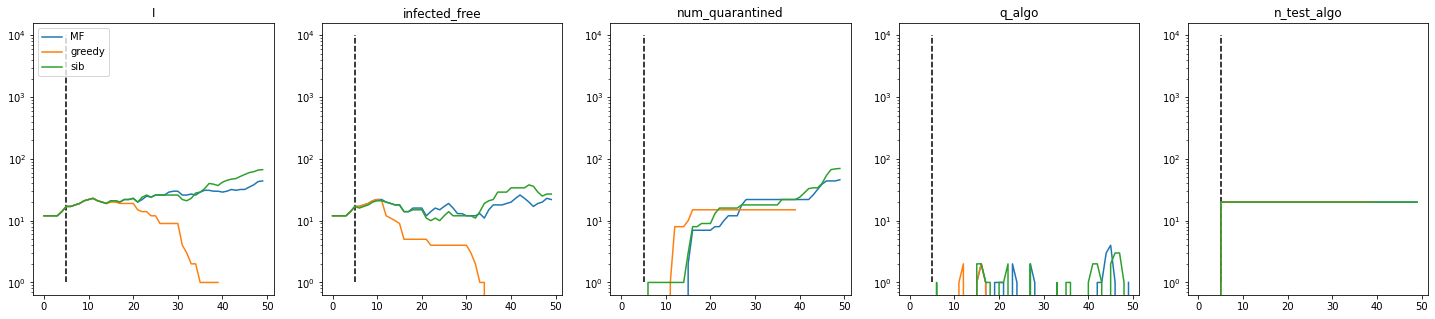

In [86]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
to_plot = ['I', 'infected_free', 'num_quarantined', "q_algo", "n_test_algo"]
for s in ress.keys():
    for il, l in enumerate(to_plot):
        if s != "no_intervention":
            axs[il].plot(range(T), ress[s][l], label=s)
            if l != "aurI":
                axs[il].set_yscale("log")
                axs[il].vlines(initial_steps, ymin=1, ymax=10**4,
                               linestyle="--", alpha=0.5, color="black")
            else:
                axs[il].vlines(initial_steps, ymin=0, ymax=1,
                               linestyle="--", alpha=0.5, color="black")

            axs[il].set_title(l, fontsize=12)
    axs[0].legend(loc='upper left')

#fig.suptitle(f"num test algo {num_test_algo} - adoption_fraction {adoption_fraction}")
fig.show()


In [87]:
import pandas as pd

filename = f"sib_N_{N}_T_{T}_obs_{num_test_algo}_sym_obs_{fraction_sym_obs}_seed_{seed}_states.pkl"

object = pd.read_pickle(output_dir + filename)
object['transmissions']

[[[340.2019315565212, 70, 687], [131.95647805315014, 70, 767]],
 [],
 [],
 [],
 [[443.8642544391405, 457, 169], [446.58557659977487, 457, 859]],
 [],
 [[496.8092497974145, 425, 71]],
 [[180.7882932107915, 527, 811]],
 [[460.8312880643761, 811, 552],
  [351.8889250369396, 811, 706],
  [314.6034360979932, 811, 461]],
 [[273.9303402120962, 541, 20], [536.1035919047368, 541, 158]],
 [[369.49174753449853, 198, 325], [374.80358503279535, 459, 681]],
 [],
 [[557.962939520921, 278, 663]],
 [],
 [[556.5820615309623, 461, 853]],
 [],
 [[639.6565014806564, 706, 580], [701.1784311631366, 706, 638]],
 [[576.895929009193, 20, 434]],
 [[450.4022891933846, 687, 136]],
 [[799.6532574223716, 169, 726]],
 [],
 [[746.2472192386025, 325, 265],
  [625.9571263362834, 325, 24],
  [808.7581793433757, 136, 544],
  [611.7930289026516, 136, 624]],
 [],
 [[879.2083996822297, 163, 427], [613.6761141561159, 163, 887]],
 [],
 [],
 [],
 [[903.6318364278113, 296, 633]],
 [[808.0428845981552, 24, 544],
  [975.6866533383

In [88]:
x, y = object["ROC"][12]


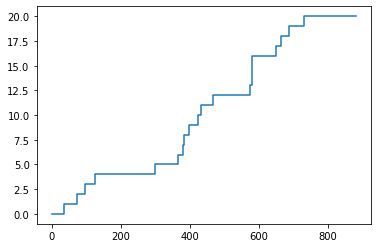

In [89]:
plt.plot(x,y)